# Fall Detection Data Multi-Classification with Logistic Regression and Gradient Descent

## Load Data
Falls among the elderly is an important health issue. Fall detection and movement tracking are therefore instrumental in addressing this issue. Here I respond to the challenge of classifying different movements as a part of a system designed to fulfill the need for a wearable device to collect data for fall and near-fall analysis. Four different fall trajectories (forward, backward, left and right), three normal activities (standing, walking and lying down) and near-fall situations are identified and detected.  
-TIME : monitoring time  
-SL : sugar level  
-EEG : EEG monitoring rate  
-BP : Blood pressure  
-HR : Heart bear rate  
-CIRCULATION : Blood circulation  
-ACTIVITY : 
    0. -Standing   
    1. -Walking  
    2. -Sitting  
    3. -Falling  
    4. -Cramps  
    5. -Running

In [1]:
%%HTML
<style type='text/css'>
table.dataframe td, table.dataframe th{
    border: 1px black solid !important;
    color: black !important;
}

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
sb.set_style('darkgrid')

In [3]:
dtype = {'ACTIVITY':'int',
        'TIME':'float64',
        'SL':'float64',
        'EGG':'float64',
        'BP':'int64',
        'HR':'int64',
        'CIRCULATION':'int64'}
fd = pd.read_csv(r'D:\python/Multiclass_Logistic_Regression\falldetection.csv', dtype=dtype)
fd.head()

,ACTIVITY,TIME,SL,EEG,BP,HR,CIRCULATION
0,3,4722.92,4019.64,-1600.00,13,79,317
1,2,4059.12,2191.03,-1146.08,20,54,165
2,2,4773.56,2787.99,-1263.38,46,67,224
3,4,8271.27,9545.98,-2848.93,26,138,554
4,4,7102.16,14148.80,-2381.15,85,120,809


In [4]:
print('Check null in the dataset:\n{a} \n\nThe shape of the dataset: {b} x {c}'
      .format(a=fd.isna().sum(),b=fd.shape[0], c=fd.shape[1]))

Check null in the dataset:
ACTIVITY       0
TIME           0
SL             0
EEG            0
BP             0
HR             0
CIRCULATION    0
dtype: int64 

The shape of the dataset: 16382 x 7


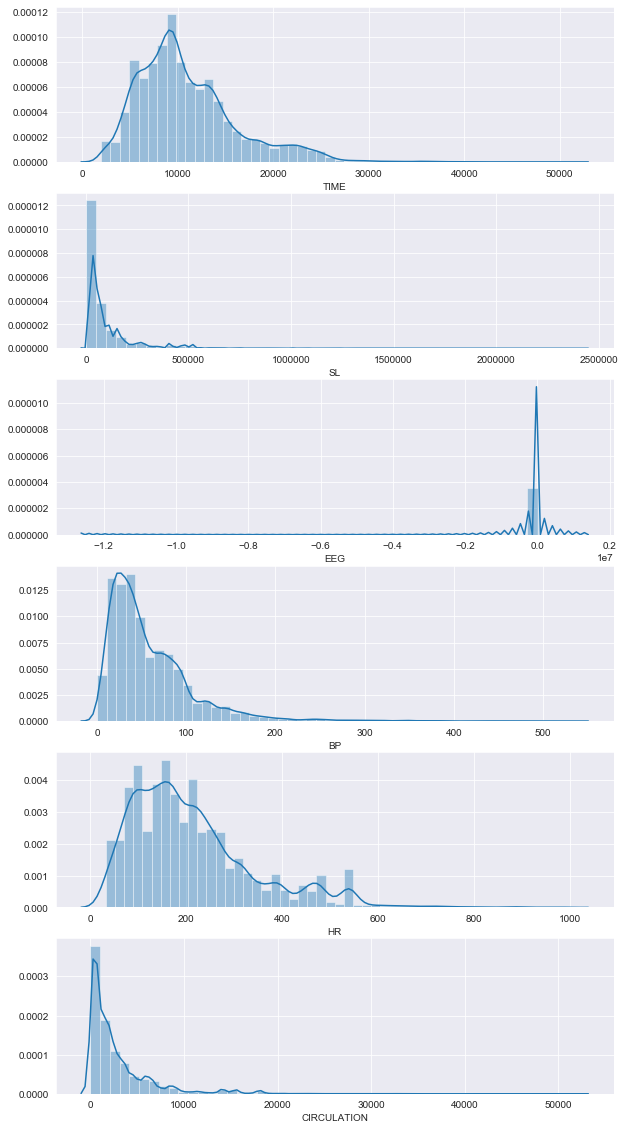

In [5]:
fig = plt.figure(figsize=(10,20))
for i in range(fd.shape[1]-1):
    fig.add_subplot(fd.shape[1]-1,1,i+1)
    sb.distplot(fd[fd.columns[i+1]])

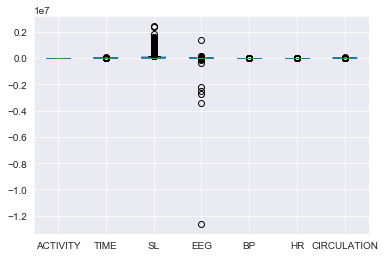

In [6]:
fd.boxplot(notch=True)

Looks like we have outliers in the EEG column. -> Cut the last small part of the distribution.  
And also the SL column.

In [7]:
fd = fd[(fd['EEG']>fd['EEG'].quantile(0.001)) & (fd['EEG']<fd['EEG'].quantile(0.999))] # cut 0.1% from both side
fd = fd[fd['SL']<fd['SL'].quantile(0.9)] # cut the highest 10% of the data
fd = fd.reset_index(drop=True) # reset the indices for further splitting

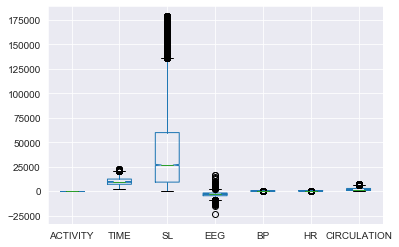

In [8]:
fd.boxplot(notch=True)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text yticklabel objects>)

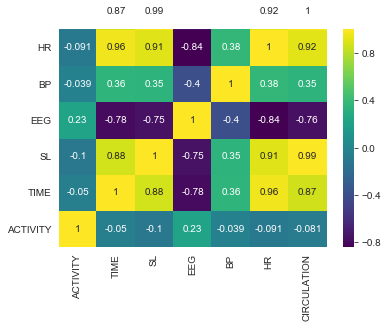

In [9]:
fig, ax = plt.subplots()
ax=sb.heatmap(fd.corr(), annot=True, cmap='viridis')
ax.set_ylim(0, 6)
plt.yticks(rotation=0) 

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit_transform(fd.iloc[:,1:])
print(pca.explained_variance_ratio_)

[0.99723367 0.00192719]


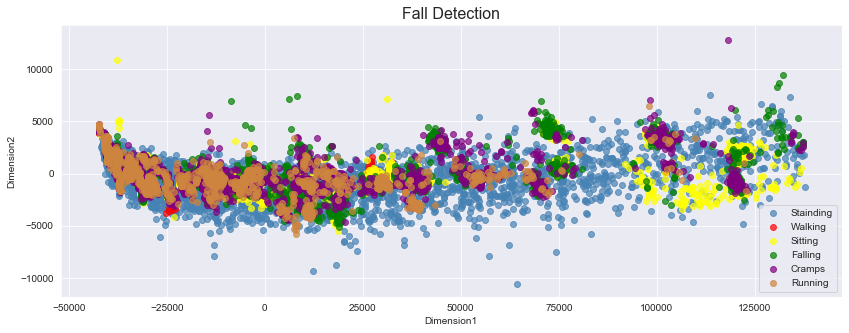

In [11]:
fd_pca = pd.DataFrame(np.c_[pca.fit_transform(fd.iloc[:,1:]),fd.iloc[:,0]], columns=['Dim1','Dim2','Activity'])
colors = ['steelblue','red','yellow','green','purple','peru']
activities_label = [0,1,2,3,4,5]
activities = ['Stainding', 'Walking', 'Sitting', 'Falling', 'Cramps', 'Running']

ax = plt.figure(figsize=(14,5))
for i in range(len(colors)):
    plt.scatter(fd_pca.loc[fd_pca['Activity']==activities_label[i],'Dim1'],
                fd_pca.loc[fd_pca['Activity']==activities_label[i],'Dim2'],
                c=colors[i], label=activities[i], alpha=0.7)
plt.xlabel('Dimension1',fontsize=10)
plt.ylabel('Dimension2',fontsize=10)
plt.title('Fall Detection', fontsize=16)
plt.legend()
plt.show()

## Preprocessing
### Standardization
Because not all variables are on the same scale, we have to standardize them into z-score in order to make our prediction model more explainable.
$$z_i = \frac{x_i-mean(x)}{std(x)}$$

In [12]:
fd_x = fd.iloc[:,1:]
fd_y = fd['ACTIVITY']

In [13]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(fd_x)
fd_z = scaler.transform(fd_x)
print(fd_z)

[[-1.34805922 -0.86518683  0.87021143 -0.94449746 -1.14233796 -0.91021951]
 [-1.52818046 -0.90716393  1.07334126 -0.77918119 -1.42533197 -0.99912729]
 [-1.33431812 -0.89346027  1.02084934 -0.16514933 -1.27817509 -0.96461704]
 ...
 [-0.22206811 -0.32732776  0.30188468 -0.47216526 -0.27071639 -0.29780868]
 [-0.52965267 -0.34990473  0.27940221  1.03929778 -0.27071639 -0.2059763 ]
 [-0.08753073 -0.05876391  0.25713454 -0.75556458  0.18207404  0.00693444]]


### Splitting Data
Firstly I have to add a column with 1 for constant term in logistic regression; then split the data randomly into training set and testing set.
$$1X = [\tilde{1}\;X]\;where \; X\in\mathbb{R}^{n\times m},\;\tilde{1}\in\mathbb{R}^{n \times 1}$$
and $m$ is the number of columns of the original dataset.

In [14]:
n = len(fd_y)
fd_1z = np.c_[np.ones((n,1)), fd_z]
print('{a}, \n{b}'.format(a = fd_1z.round(7), b = fd_y))

[[ 1.        -1.3480592 -0.8651868 ... -0.9444975 -1.142338  -0.9102195]
 [ 1.        -1.5281805 -0.9071639 ... -0.7791812 -1.425332  -0.9991273]
 [ 1.        -1.3343181 -0.8934603 ... -0.1651493 -1.2781751 -0.964617 ]
 ...
 [ 1.        -0.2220681 -0.3273278 ... -0.4721653 -0.2707164 -0.2978087]
 [ 1.        -0.5296527 -0.3499047 ...  1.0392978 -0.2707164 -0.2059763]
 [ 1.        -0.0875307 -0.0587639 ... -0.7555646  0.182074   0.0069344]], 
0        3
1        2
2        2
3        4
4        4
        ..
14708    4
14709    3
14710    2
14711    4
14712    3
Name: ACTIVITY, Length: 14713, dtype: int32


In [15]:
ratio = 0.8
np.random.seed(576)
indices = np.random.permutation(n)
split = int(np.floor(ratio * n))
train_ind = indices[:split]
test_ind = indices[split:]
x_train = fd_1z[train_ind]
y_train = fd_y[train_ind]
x_test = fd_1z[test_ind]
y_test = fd_y[test_ind]

In [16]:
print('The shape of training set: Matrix:{a} and Target:{b} \nThe shape of testing set: Matrix:{c} and Target:{d}'
      .format(a=x_train.shape, c=x_test.shape, b=y_train.shape, d=y_test.shape))

The shape of training set: Matrix:(11770, 7) and Target:(11770,) 
The shape of testing set: Matrix:(2943, 7) and Target:(2943,)


### Process Target Variable
Becasue we will apply softmax function for multiclassification, there are as many as the number of classes for neurons at the last layer of classifier. Thus, each class label will be transfered into an array with 0 and 1 by one-hot encoding. For example, if there are 3 classes, the arrays will be [1,0,0], [0,1,0], and [0,0,1].  
0. -Standing   
1. -Walking  
2. -Sitting  
3. -Falling  
4. -Cramps  
5. -Running

In [17]:
pd.Series([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]],
          index = ['Standing','Walking','Sitting','Falling','Cramps','Running'])

Standing    [1, 0, 0, 0, 0, 0]
Walking     [0, 1, 0, 0, 0, 0]
Sitting     [0, 0, 1, 0, 0, 0]
Falling     [0, 0, 0, 1, 0, 0]
Cramps      [0, 0, 0, 0, 1, 0]
Running     [0, 0, 0, 0, 0, 1]
dtype: object

In [18]:
activities = ['Stainding', 'Walking', 'Sitting', 'Falling', 'Cramps', 'Running']
one_hot = [{0:1, 1:0, 2:0, 3:0, 4:0, 5:0},
           {0:0, 1:1, 2:0, 3:0, 4:0, 5:0},
           {0:0, 1:0, 2:1, 3:0, 4:0, 5:0},
           {0:0, 1:0, 2:0, 3:1, 4:0, 5:0},
           {0:0, 1:0, 2:0, 3:0, 4:1, 5:0},
           {0:0, 1:0, 2:0, 3:0, 4:0, 5:1}]

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
for act in range(len(one_hot)):
    y_train[activities[act]] = y_train['ACTIVITY'].map(one_hot[act])
    y_test[activities[act]] = y_test['ACTIVITY'].map(one_hot[act])
y_train_label = y_train['ACTIVITY']
y_test_label = y_test['ACTIVITY']
y_train = y_train.drop(columns='ACTIVITY')
y_test = y_test.drop(columns='ACTIVITY')

In [19]:
y_train.head()

,Stainding,Walking,Sitting,Falling,Cramps,Running
3066,0,0,0,0,0,1
1449,0,0,1,0,0,0
11348,0,0,0,1,0,0
13503,0,0,0,0,1,0
3708,0,0,0,0,1,0


In [27]:
np.random.seed(318)
x_train = x_train
y_train = y_train.values
x_test = x_test
y_test = y_test.values
w_init = np.random.rand(len(activities),x_train.shape[1])

##  Multinomial Logistic Regression

###  Process
The process and concept behind Multi-class Logistic Regression is to use a linear regression to obtain outputs of samples for each classes and then transfer these outputs into probabilities form with **softmax** function. With softmax function, we can choose the largest value of probabilities and consider it as the sample's class. Next, we use **CrossEntropy** as loss function and derive it in order to obtain **gradient** for updating the weights. By doing so iteratively, there are ultimate weights for each classes which will be used in testing set.

### Linear Regression Output
Suppose there are $n$ samples, $(s+1)$ columns and $K$ classes in the dataset and the output of class $k$ over linear regression is:
$$f_{i,k} = x_iw_k^T$$
where $x_i,\;i=1,...,n$ and $w_k$ is the weights for classes $k$.

In [20]:
def outputs(x, w):
    return x.dot(w.T)

### Softmax Function
&emsp; Softmax is a method that widely used in machine learning. In Softmax, it will compute probability of each class for each sample and take the largest value as the predicted class of the sample.
$$p_k=\frac{e^{f_k}}{\sum_{j} e^{f_j}}$$
where $f_k=xw_k^T,\;x\in \mathbb{R}^{n\times (s+1)}\; and \; w^k\in \mathbb{R}^{1 \times (s+1)}$.  
&emsp; In order to avoid overflow in Python, I minus the maximum without changing output from the original implementation.  
  $$p_k = \frac{e^{-m}e^{f_k}}{e^{-m}\sum_{j} e^{f_j}}=\frac{e^{f_k-m}}{\sum_{j} e^{f_j-m}}$$
where $m$ is the maximum among $f_k,\; k=1,...,K$.

In [21]:
def softmax(outputs):
    max_ = np.reshape(np.max(outputs, axis=1), (len(outputs), 1))
    return np.exp(outputs-max_)/np.sum(np.exp(outputs-max_), axis=1, keepdims=True)

### CrossEntropy
In order to update the weights, we need loss function, CrossEntropy, and find its gradient. Before CrossEntropy, let me define the Entropy (Information Gain):
$$I(x)_k = -log(p_k)$$
And the CrossEntropy for a single sample is defined as below:
$$L_i = -\sum_{k=1}^{K}y_{i,k}log(p_k)$$
where $y_{i,k}$ is the value of either 0 or 1 which depends on whether the sample $x_i$ belongs to class $k$. Suppose the predicted class is 2 and the true class is also 2; then $y_{i,k}=1$.
The overall loss is :
$$L = \frac{-1}{n}\sum_{i=1}^{n}\sum_{k=1}^{K}y_{i,k}log(p_k)$$

In [22]:
def CrossEntropy(y, outputs):
    a = np.log(softmax(outputs))
    return -np.sum(y*a)

### Gradient Derivation
First I define the gradient as $d_{w_{i,k}}=\frac{\partial L_i}{\partial w_k}$ is the gradient of sample $x_i$ for class $k$. Despite of deriving $\frac{\partial L_i}{\partial w_k}$, because $L_i$ is the function of $f_m$ and $f_m$ is the function of $w_k$, it's easier to derive $\frac{\partial L_i}{\partial f_m}$ and $\frac{\partial f_m}{\partial w_k}$. As a result,
$$\frac{\partial L_i}{\partial w_k} = \frac{\partial L_i}{\partial f_m}\frac{\partial f_m}{\partial w_k}$$

$$\because f_m = xw_k^T \;\; \therefore \frac{\partial f_m}{\partial w_k}=x$$


$\because L_i = -\sum_{k=1}^{K}y_{i,k}log(p_k),\; p_k=\frac{e^{f_k}}{\sum_{j} e^{f_j}}$,here we calculate $\frac{\partial p_k}{\partial f_m}$ first. Because $p_k$ is the function composition of $f_m$, we need to discuss two conditions which are $k=m$ and $k \neq m$.  
$$
\begin{eqnarray}
\mathbf{1.}\;\;k=m:\\
\frac{\partial p_k}{\partial f_m}
&=& \frac{\partial}{\partial f_m}\left( \frac{e^{f_m}}{\sum_{j} e^{f_j}} \right)\\
&=& e^{f_m}\left( \sum_{j} e^{f_j} \right)^{-1} - \left( e^{f_m} \right)^{2} \left( \sum_{j} e^{f_j} \right)^{-2}\\
&=& p_m(1-p_m)\\
\mathbf{2.}\;\;k \neq m: \\ 
\frac{\partial p_k}{\partial f_m}
&=& \frac{\partial}{\partial f_m}\left( \frac{e^{f_k}}{\sum_{j} e^{f_j}} \right)\\
&=& -e^{f_k}e^{f_m}\left( \sum_{j} e^{f_j} \right)^{-2}\\
&=& -p_kp_m
\end{eqnarray}
$$

$$
\begin{eqnarray}
\frac{\partial L_i}{\partial f_m}
&=& -\sum_{k} y_{i,k}\frac{\partial logp_k}{\partial f_m} \qquad\qquad\qquad\qquad \left( \frac{\partial logp_k}{\partial p_k} = \frac{1}{p_k}  \Rightarrow \partial logp_k = \frac{\partial p_k}{p_k}\right)\\
&=& -\sum_{k} y_{i,k}\frac{1}{p_k}\frac{\partial p_k}{\partial f_m}\\
&=& \sum_{k=m}y_{i,k}\frac{1}{p_k}p_k(1-p_k) + \sum_{k \neq m}y_{i,k}\frac{1}{p_k}p_kp_m\\
&=&\sum_{k=m}y_{i,k}(1-p_k) + \sum_{k \neq m}y_{i,k}p_m\\
&=& -y_{i,m}(1-p_m) + \sum_{k \neq m}y_{i,k}p_m\\
&=& -y_{i,m} + -y_{i,m}p_m +  \sum_{k \neq m}y_{i,k}p_m\\
&=& p_m\left( \sum_k y_{i,k} \right) - y_{i,m}\\
&=& p_m - y_{i,m}
\end{eqnarray}
$$

Finally, we can calculate the gradient $\frac{\partial L_i}{\partial w_k} = x_i^T(p_m - y_{i,m})$.

In [23]:
def softmax_gradient(x, y, outputs, num_classes):
    grad = []
    for k in range(num_classes):
        g = []
        for i in range(len(x)):
            g_ = x[i] * (softmax(outputs)[i] - y[i])[k]
            g.append(g_)
        grad.append(np.mean(g, axis=0))
    return np.array(grad)

### Accuracy
$$Accuracy = \frac{1}{n}\sum_{i=1}^{n}I(predicted\;label = true\;label)$$

In [24]:
def accuracy(x, y, w):
    label_pred = softmax(outputs(x, w)).argmax(axis=1)
    return np.sum(label_pred == y) / len(x)

In [29]:
def softmax_multiclassification(x_train, y_train, y_train_label, x_test, y_test, y_test_label, w_init, n_iters, lambda_):
    n_classes = len(w_init)
    w_ = [w_init]
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    w = w_init
    for j in range(n_iters):
        outputs_train = outputs(x_train, w)
        outputs_test = outputs(x_test, w)
        gradient = softmax_gradient(x_train, y_train, outputs_train, n_classes)
        train_loss = CrossEntropy(y_train, outputs_train)
        test_loss = CrossEntropy(y_test, outputs_test)
        w = w - lambda_ * gradient
        train_acc_ = accuracy(x_train, y_train_label, w)
        test_acc_ = accuracy(x_test, y_test_label, w)
        
        train_acc.append(train_acc_)
        test_acc.append(test_acc_)
        w_.append(w)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        if (j+1)%10 == 0:
            print('Gradient Descent for Softmax Multi-classification Iteration ({a}/{b}):\n train loss={c}, test loss={d}, training acc={e}, testing acc={f}'.format(
                    a = j+1, b = n_iters, c = train_loss.round(5), d = test_loss.round(5), e = train_acc_.round(5), f = test_acc_.round(5)))
    
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    ax[0].plot(np.arange(1, n_iters+1, 1), train_acc, color='b', marker='*', label='Training Accuracy')
    ax[0].plot(np.arange(1, n_iters+1, 1), test_acc, color='r', marker='*', label='Testing Accuracy')
    ax[0].set_xlabel('iterations')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Accuracy over iterations')
    leg1 = ax[0].legend(loc='best', shadow=True)
    leg1.draw_frame(False)
    
    ax[1].plot(np.arange(1, n_iters+1, 1), train_losses, color='b', marker='*', label='Training Loss')
    ax[1].plot(np.arange(1, n_iters+1, 1), test_losses, color='r', marker='*', label='Testing Loss')
    ax[1].set_xlabel('iterations')
    ax[1].set_ylabel('Loss(Cross Entropy)')
    ax[1].set_title('Loss (Cross Entropy) over iterations')
    leg2 = ax[1].legend(loc='best', shadow=True)
    leg2.draw_frame(False)
    return np.array(train_losses), np.array(test_losses), np.array(train_acc), np.array(test_acc), np.array(w_)

Gradient Descent for Softmax Multi-classification Iteration (10/60):
 train loss=18503.78064, test loss=4611.11715, training acc=0.36321, testing acc=0.36969
Gradient Descent for Softmax Multi-classification Iteration (20/60):
 train loss=18223.11202, test loss=4532.42813, training acc=0.36669, testing acc=0.37887
Gradient Descent for Softmax Multi-classification Iteration (30/60):
 train loss=18121.87313, test loss=4503.2293, training acc=0.3706, testing acc=0.38668
Gradient Descent for Softmax Multi-classification Iteration (40/60):
 train loss=18067.76511, test loss=4487.67073, training acc=0.37587, testing acc=0.38838
Gradient Descent for Softmax Multi-classification Iteration (50/60):
 train loss=18033.07979, test loss=4477.93549, training acc=0.37952, testing acc=0.3911
Gradient Descent for Softmax Multi-classification Iteration (60/60):
 train loss=18007.96037, test loss=4471.16277, training acc=0.38352, testing acc=0.39687


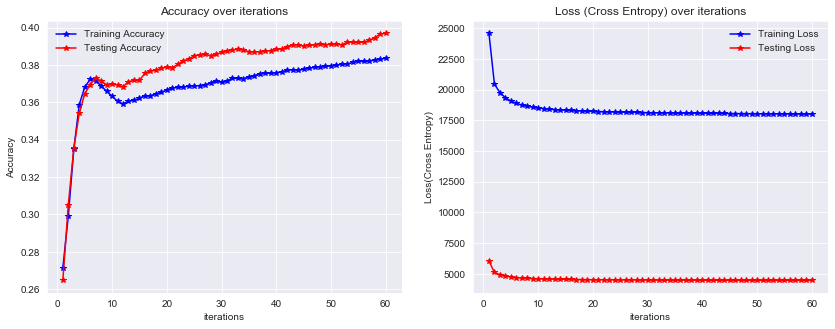

In [32]:
train_losses, test_losses, train_acc, test_acc, w_list = softmax_multiclassification(x_train, y_train, y_train_label, x_test, y_test, y_test_label, w_init, 60, 1.5)